# Scrapping Top Repositories For Topics On Github


Introduction:
- Web scraping is data scraping used for extracting data from websites. The web scraping software may directly access the World Wide Web using the Hypertext Transfer Protocol or a web browser. While web scraping can be done manually by a software user, the term typically refers to automated processes implemented using a bot or web crawler. It is a form of copying in which specific data is gathered and copied from the web, typically into a central local database or spreadsheet, for later retrieval or analysis.
- GitHub is a for-profit company that offers a cloud-based Git repository hosting service. Essentially, it makes it a lot easier for individuals and teams to use Git for version control and collaboration.
- Tools used python, requests, BeautifulSoup, pandas

Here are the steps we'll follow:

- We're going to scrape https://github.com/topics
- We'll get a list of topic. For each topic, we'll get topic title, topic page URL and topic description
- For each topic, we,ll get the top 25 repositories in the topic from the topic page
- For each repository, we'll grab the repo name, username, stars and repo URL
- For each topic we'll create a CSV file in the following format:

```
Repo Name,Repo Name,Repo Name,Repo Name
three.js,mrdoob,71800,https://github.com/mrdoob/three.js
libgdx,libgdx,18500,https://github.com/libgdx/libgdx

```

## Scrape the list of Topics from Github

- use requests to download the page
- use BS4 to convert and extract information
- convert to a pandas dataframe

Let's write a function to download the page.

In [5]:
import requests
from bs4 import BeautifulSoup

def get_topics_page():
    # take the page URL
    topics_url = 'https://github.com/topics'
    
    # download the page
    response = requests.get(topics_url)
    if response.status_code != 200:
        raise Exception('Filed to load page {}'.format(topic_url))
    # parse the page
    doc = BeautifulSoup(response.text, 'lxml')
    return doc


- Firstly I have imported the required libraries as I mentioned above 
- Made a function called `get_topics_page` it takes the page, and download it by using requests 
- To check weather it is downloaded or not , I used status code
- to parse the page I used bs4 

In [6]:
doc = get_topics_page()

Let's create some helper functions to parse information from the page.

To get topic titles, we can pick `p` tags with the `class` ...

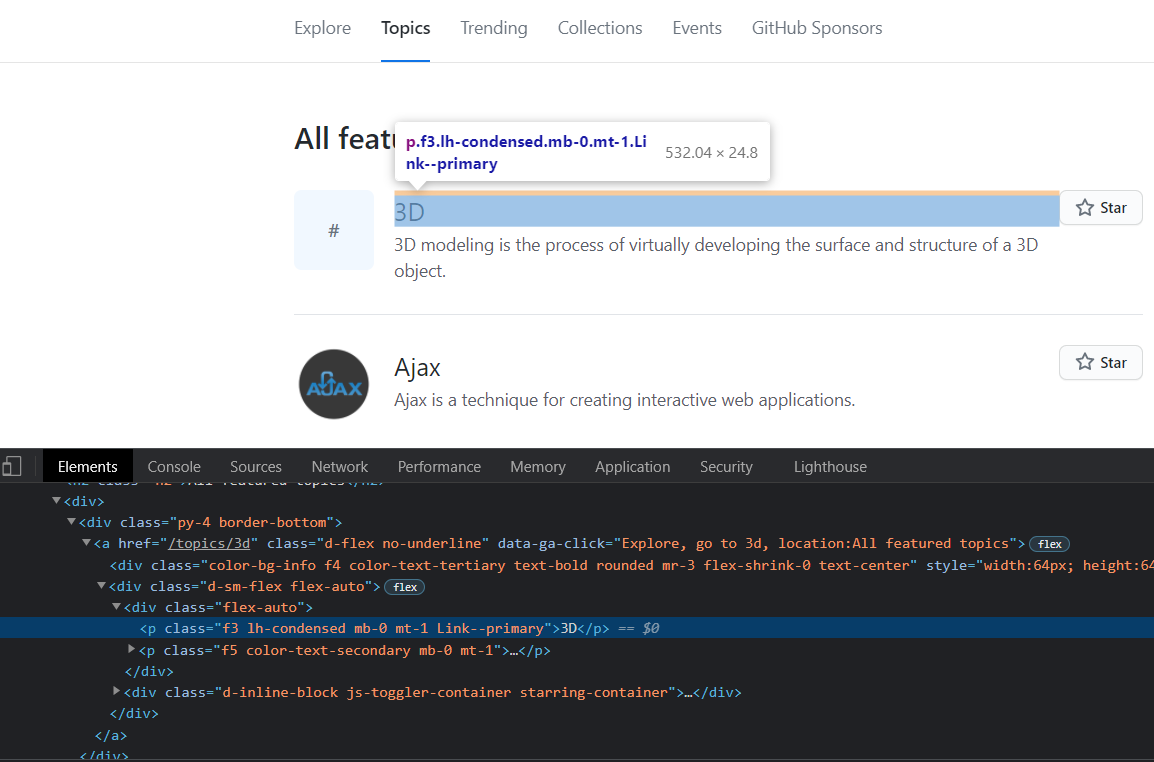

In [7]:
def get_topic_titles(doc):
    selection_class = "f3 lh-condensed mb-0 mt-1 Link--primary"
    topic_title_tags = doc.find_all('p', {'class' : selection_class})
                                    
    topic_titles = []
    for tag in topic_title_tags:
        topic_titles.append(tag.text)
    return topic_titles


`get_topic_titles` can be used to get the list of titles

In [8]:
titles = get_topic_titles(doc)

In [9]:
len(titles)

30

In [10]:
titles[:5]

['3D', 'Ajax', 'Algorithm', 'Amp', 'Android']

Similarly we have defined functions for descriptions and URLs

In [11]:
def get_topic_descs(doc):
    desc_selector = 'f5 color-text-secondary mb-0 mt-1'
    topic_desc_tags = doc.find_all('p', {'class' : desc_selector})
    
    topic_descs = []

    for tag in topic_desc_tags:
        topic_descs.append(tag.text.strip())
    return topic_descs
    

In [12]:
def get_topic_urls(doc):
    topic_link_tags = doc.find_all('a', {'class' : 'd-flex no-underline'})
    
    topic_urls = []
    base_url = "https://github.com"

    for tag in topic_link_tags:
        topic_urls.append(base_url + tag['href'])

    return topic_urls
    

Let's put this all together into a single function 

In [13]:
def scrape_topics():
    topics_url = 'https://github.com/topics'
    response = requests.get(topics_url)
    if response.status_code != 200:
        raise Exception('Filed to load page{}'.format(topic_url))
    doc = BeautifulSoup(response.text, 'lxml')
    topics_dict = {
        'title': get_topic_titles(doc),
        'description' : get_topic_descs(doc),
        'url' : get_topic_urls(doc)
    }
    return pd.DataFrame(topics_dict)

## Get the top 25 repositories from a topic page

Taking the top 25 repositories information:
- Usernames
- Repository names
- Repository URLs
- Stars count


In [14]:
def get_topic_page(topic_url):
    # download the page
    response = requests.get(topic_url)
    
    # check successful response
    if response.status_code != 200:
        raise Exception('Filed to load page{}'.format(topic_url))
        
    # parse using beautiful soup
    topic_doc = BeautifulSoup(response.text, 'lxml')
    return topic_doc

In [15]:
doc = get_topic_page("https://github.com/topics/3d")

To get the repository info , we need username, repository name, stars count and repository URL, So, after inspecting I found that thses 
things are comming under 'h1' tags 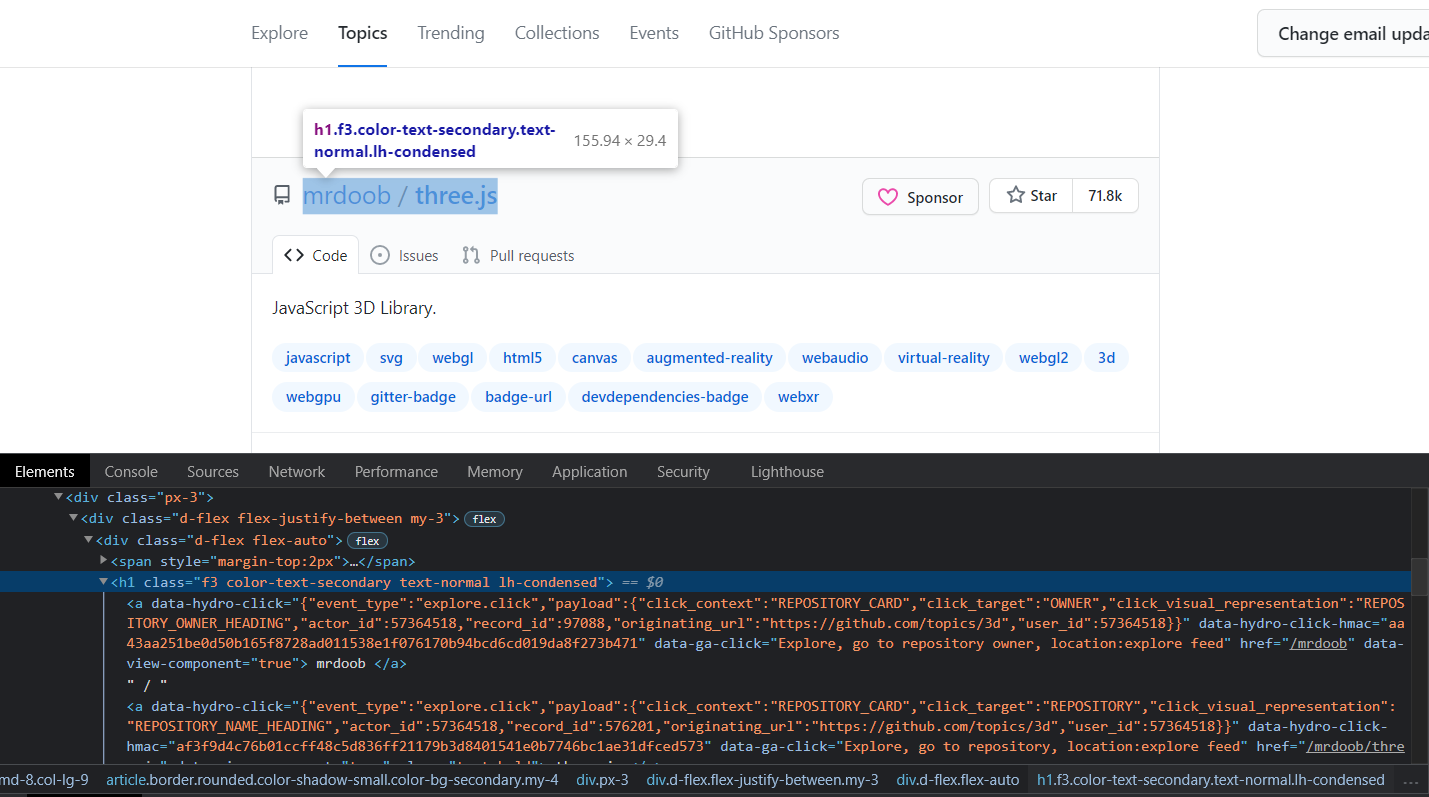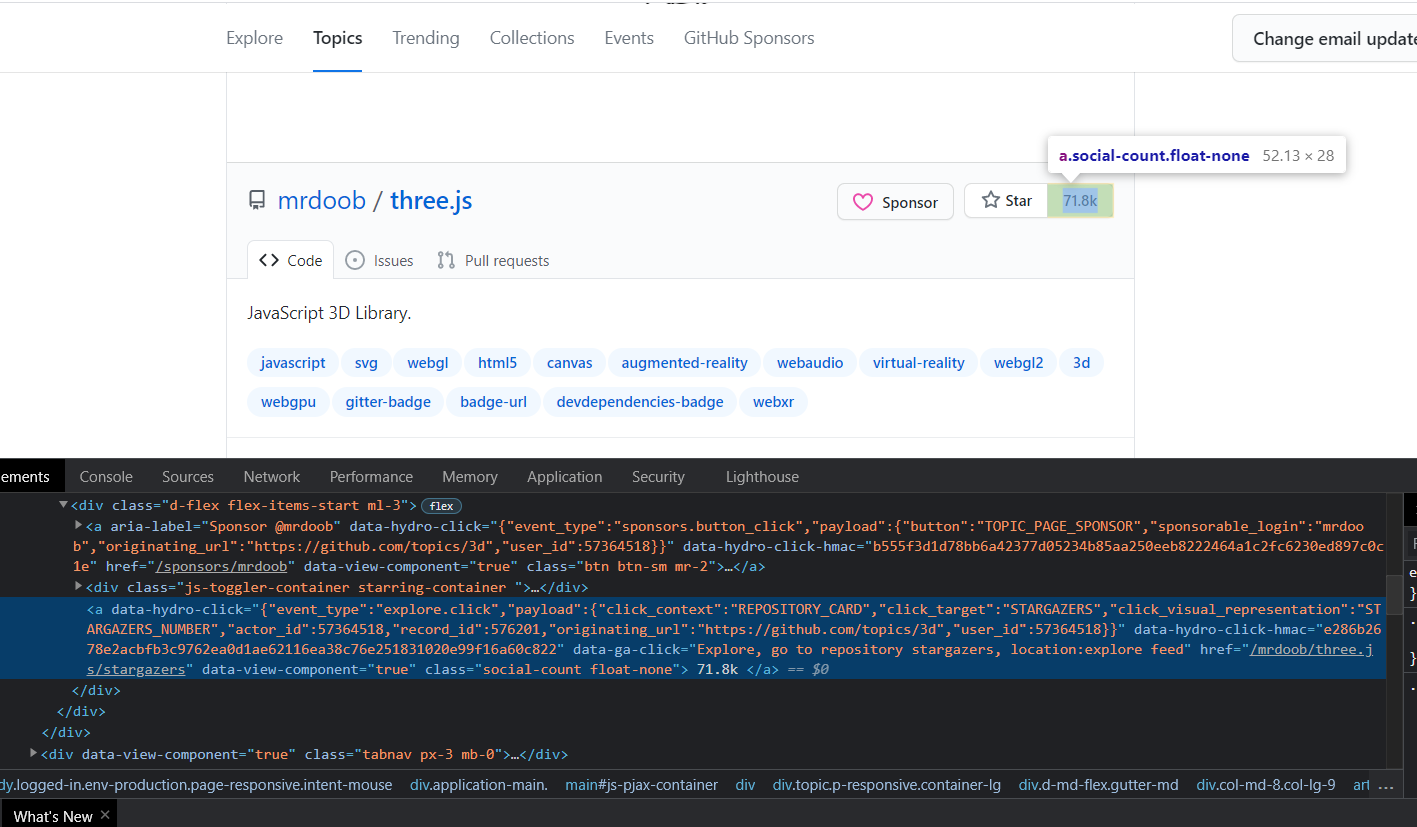

In [23]:
# To get the username , repo_name and repo_url
h1_selection_class = "f3 color-text-secondary text-normal lh-condensed"
repo_tags = doc.find_all('h1', {'class' : h1_selection_class})

# To get the `a` tags in h1 tags
a_tags = repo_tags[0].find_all('a')

base_url = 'https://github.com'
repo_url = base_url + a_tags[1]['href']

star_selection = "social-count float-none"
star_tags = doc.find_all('a', {'class' : star_selection })

In [27]:
def parse_star_count(stars_str):
    stars_str = stars_str.strip()
    if stars_str[-1] == 'k':
        return int(float(stars_str[:-1]) * 1000)
    return int(stars_str)
parse_star_count(star_tags[0].text.strip())    

71800

In [28]:
def get_repo_info(h1_tag, star_tag):
    # returns all the required info about a repository
    a_tags = h1_tag.find_all('a')
    username = a_tags[0].text.strip()
    repo_name = a_tags[1].text.strip()
    repo_url = base_url + a_tags[1]['href']
    stars = parse_star_count(star_tag.text.strip())
    return username, repo_name, stars, repo_url


In [29]:
get_repo_info(repo_tags[0], star_tags[0])

('mrdoob', 'three.js', 71800, 'https://github.com/mrdoob/three.js')

In [30]:
import pandas as pd
import os


def get_topic_repos(topic_doc):
    
    # get the h1 tags containing repo_title, repo_url and username
    h1_selection_class = "f3 color-text-secondary text-normal lh-condensed"
    repo_tags = topic_doc.find_all('h1', {'class' : h1_selection_class})
    
    # get star tags 
    star_tags = topic_doc.find_all('a', {'class' : star_selection })
    
    topic_repos_dict = {'username' : [], 'repo_name' : [], 'stars' : [], 'repo_url' : []}
    
    # get repo info
    for i in range(len(repo_tags)):
        repo_info = get_repo_info(repo_tags[i], star_tags[i])
        topic_repos_dict['username'].append(repo_info[0])
        topic_repos_dict['repo_name'].append(repo_info[1])
        topic_repos_dict['stars'].append(repo_info[2])
        topic_repos_dict['repo_url'].append(repo_info[3])
    
    return pd.DataFrame(topic_repos_dict)

In [31]:
def scrape_topic(topic_url, path):
    
    if os.path.exists(path):
        print("the file {} already exists. skipping...".format(path))
        return
    topic_df = get_topic_repos(get_topic_page(topic_url))
    
    topic_df.to_csv(path, index = None)

## Putting it all together

- we have a function to get the list of topics 
- we have a function to create a CSV file for scraped repos from a topics page
- Let's create a function to put them together

In [32]:
def scrape_topics_repos():
    print('scrapping list of topics')
    topics_df = scrape_topics()
    
    os.makedirs('data', exist_ok = True)
    
    for index, row in topics_df.iterrows():
        #print('scrapping top repositories for "{}"'.format(row(['title'])))
        scrape_topic(row['url'],'data/{}.csv'.format(row['title']))

Let's run it to scrape the top repos for all the topics on the first page of https://github.com/topics

In [33]:
scrape_topics_repos()

scrapping list of topics
the file data/3D.csv already exists. skipping...
the file data/Ajax.csv already exists. skipping...
the file data/Algorithm.csv already exists. skipping...
the file data/Amp.csv already exists. skipping...
the file data/Android.csv already exists. skipping...
the file data/Angular.csv already exists. skipping...
the file data/Ansible.csv already exists. skipping...
the file data/API.csv already exists. skipping...
the file data/Arduino.csv already exists. skipping...
the file data/ASP.NET.csv already exists. skipping...
the file data/Atom.csv already exists. skipping...
the file data/Awesome Lists.csv already exists. skipping...
the file data/Amazon Web Services.csv already exists. skipping...
the file data/Azure.csv already exists. skipping...
the file data/Babel.csv already exists. skipping...
the file data/Bash.csv already exists. skipping...
the file data/Bitcoin.csv already exists. skipping...
the file data/Bootstrap.csv already exists. skipping...
the fil

we can check that the CSVs were created properly

In [55]:
# read and display a CSV using pandas

In [59]:
pd.read_csv("data/Android.csv")

,username,repo_name,stars,repo_url
0,flutter,flutter,122000,https://github.com/flutter/flutter
1,justjavac,free-programming-books-zh_CN,80700,https://github.com/justjavac/free-programming-...
2,Genymobile,scrcpy,50500,https://github.com/Genymobile/scrcpy
3,Hack-with-Github,Awesome-Hacking,44600,https://github.com/Hack-with-Github/Awesome-Ha...
4,google,material-design-icons,43100,https://github.com/google/material-design-icons
5,wasabeef,awesome-android-ui,40700,https://github.com/wasabeef/awesome-android-ui
6,square,okhttp,40200,https://github.com/square/okhttp
7,android,architecture-samples,38900,https://github.com/android/architecture-samples
8,square,retrofit,38200,https://github.com/square/retrofit
9,Solido,awesome-flutter,36100,https://github.com/Solido/awesome-flutter


## References and Future Work

Summary:

- Firstly I have decided the page the I want scrape, then the required data, which is 'Topics' 
- After that, I decided to extract the topic titles, topic descriptions, and topic URLs.
- Then by using pandas dataframe I made CSV file out of it.
- Moving ahead, In each topic, there are millions of repositories, extracted 30 repositories from each topic,
- In each repository, got usernames, repository names, repository URLs ans stars count,
- By using pandas made CSVs out of every topics.
- lastly made folder using os.makedirs to put all the CSVs in one place 



Useful Links

- BeautifulSoup : https://www.crummy.com/software/BeautifulSoup/bs4/doc/#find-next-siblings-and-find-next-sibling

- Requests : https://realpython.com/python-requests/

- pandas : https://pandas.pydata.org/pandas-docs/stable/

Ideas for future work

- Here I have extracted only 30 repository, but we can extract more by using the same steps, In future I'll try to extract 
100 repositories from each topic